# ALBERT на WikiText-2

В этом ноутбуке мы разберём датасет WikiText-2 и реализуем модель ALBERT по оригинальной [статье](https://arxiv.org/pdf/1909.11942).

In [1]:
# %load_ext autoreload
# %autoreload 2

## I. Данные

В данном блоке мы познакомимся с данными и произведём EDA.

Датасет WikiText-2 представляет собой набор статей английской версии интернет-энциклопедии Wikipedia, предварительно отчищенных от языка разметки. Датасет можно скачать используя библиотеку datasets от Hugging Face, где он предварительно разбит на 3 выборки:

In [2]:
from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

Посмотрим на данные и на некоторые статистики:

In [3]:
dataset["train"]["text"][:8]

['',
 ' = Valkyria Chronicles III = \n',
 '',
 ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more f

От веб-разметки нас, конечно, спасли, однако предоставленные данные далеко не чистые: имеются пустые строки, названия параграфов, обособленные символами "=", а в конце каждого предложения стоят символы переноса строки. Вместе с тем, имеет место примесь других языков, что свойственно для Wikipedia, но что вряд ли сыграет нам на руку.

Также в данных присутствуют статьи, относящиеся к химии, поэтому в данных есть много коротких строчек, представляющих из себя формулы.

Уберём абзацы длиной меньше 30 символов, символы новой строки и заголовки.

In [4]:
for split in dataset:
    len_with_empty = len(dataset[split])
    len_wout_empty = len(dataset[split].filter(lambda row: len(row["text"]) > 0))
    percent = (1 - len_wout_empty / len_with_empty) * 100
    print(f"percentage of empty strings in {split}: {percent:.2f}%")


def clean(row):
    row["text"] = row["text"].replace("\n", " ")
    row["text"] = row["text"].strip()
    return row

for split in dataset:
    dataset[split] = dataset[split].map(clean)
    dataset[split] = dataset[split].filter(lambda row: len(row["text"]) > 30)
    dataset[split] = dataset[split].filter(lambda row: not row["text"].startswith("="))

Filter:   0%|          | 0/4358 [00:00<?, ? examples/s]

percentage of empty strings in test: 33.66%


Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

percentage of empty strings in train: 35.27%


Filter:   0%|          | 0/3760 [00:00<?, ? examples/s]

percentage of empty strings in validation: 34.55%


Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4358 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2219 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

Filter:   0%|          | 0/18265 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3760 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1932 [00:00<?, ? examples/s]

Проверим данные на дубликаты:

In [5]:
import pandas as pd

df_train = pd.DataFrame(dataset["train"])
duplicates_percent = df_train.duplicated().sum() / df_train.shape[0] * 100
print(f"percentage of duplicate rows in train: {duplicates_percent:.2f}%")

df_train[df_train.duplicated()]["text"].tolist()

percentage of duplicate rows in train: 0.07%


['Note : Flags indicate national team as defined under FIFA eligibility rules . Players may hold more than one non @-@ FIFA nationality .',
 'Note : Flags indicate national team as defined under FIFA eligibility rules . Players may hold more than one non @-@ FIFA nationality .',
 'Credits adapted from the liner notes of The Family Jewels .',
 'The entire highway was in Kent County .',
 'Sourced from Tommy Lawton profile at the English National Football Archive ( subscription required )',
 'Teams marked * progressed to the next stage of the competition .',
 'Teams marked † were eliminated from the competition .',
 'Note : Flags indicate national team as defined under FIFA eligibility rules . Players may hold more than one non @-@ FIFA nationality .',
 '" My Boo " ( Duet with Alicia Keys )',
 'Credits adapted from the liner notes for Fortune',
 'Note : Only the top five positions are included for both sets of standings .',
 '( Credits lifted from the album liner notes )']

Дубликатов мало и они не представляют из себя большие и содержательные абзацы — это хорошо. Удалим их.

In [6]:
seen = set()

def keep_first(ex):
    t = ex["text"]
    if t in seen:
        return False
    seen.add(t)
    return True

dataset["train"] = dataset["train"].filter(keep_first)

df_train = pd.DataFrame(dataset["train"])
assert df_train.duplicated().sum() == 0

Filter:   0%|          | 0/16736 [00:00<?, ? examples/s]

Посмотрим на статистики по оставшимся у нас данным.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

splits = {
    "train": pd.DataFrame(dataset["train"]),
    "validation": pd.DataFrame(dataset["validation"]),
    "test": pd.DataFrame(dataset["test"]),
}

rows = []
for name, df in splits.items():
    txt = df["text"].astype(str)
    sent_len = txt.str.split().map(len)
    rows.append({
        "split": name,
        "rows": len(txt),
        "passage_mean": sent_len.mean(),
        "passage_median": sent_len.median(),
        "passage_p95": sent_len.quantile(0.95),
    })

pd.DataFrame(rows).set_index("split").round(3)

,rows,passage_mean,passage_median,passage_p95
split,,,,
train,16724,119.817,111.0,256.85
validation,1762,118.624,112.0,245.00
test,1995,117.929,107.0,259.30


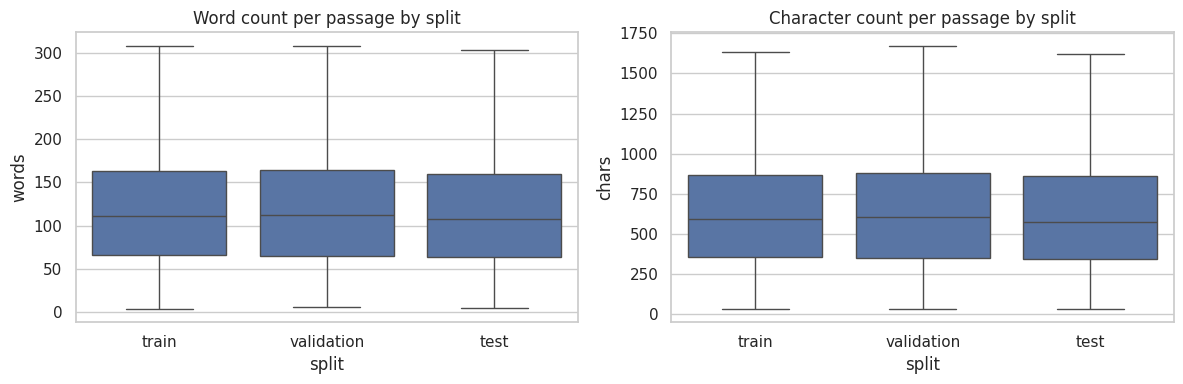

In [8]:
plot_df = []
for name, df in splits.items():
    txt = df["text"].astype(str)
    plot_df.append(pd.DataFrame({
        "split": name,
        "words": txt.str.split().map(len),
        "chars": txt.str.len(),
    }))

plot_df = pd.concat(plot_df, ignore_index=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data=plot_df, x="split", y="words", showfliers=False, ax=ax[0])
ax[0].set_title("Word count per passage by split")

sns.boxplot(data=plot_df, x="split", y="chars", showfliers=False, ax=ax[1])
ax[1].set_title("Character count per passage by split")
plt.tight_layout()
plt.show()

Сплиты имеют схожие распределения статистик, распределения данных лежат в среднем адекватно.

## II. Подготовка к обучению

In [9]:
import random
from typing import Tuple
import torch

random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

vocab_size = 30000
max_length = 512
min_frequency = 2
special_tokens = ["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]

Разобьём параграфы на предложения, учитывая, что в выводах выше видно, что предложения разделяются через " . ". Безусловно, это не самый правильный и безопасный способ разбивания абзацей на предложения, однако получаемые другим способом разбиения (например, через nltk.sent_) оказываются не лучше в силу указанной специфики данных.

In [10]:
paragraphs = {
    'train': [t.split(" . ") for t in dataset["train"]["text"]],
    'validation': [t.split(" . ") for t in dataset["validation"]["text"]],
}

for split in paragraphs:
    for paragraph in paragraphs[split]:
        for i in range(len(paragraph)):
            if not paragraph[i].endswith("."):
                paragraph[i] += "."

filename = "wikitext-train.txt"
with open(filename, "w") as f:
    for paragraph in paragraphs['train']:
        for sentence in paragraph:
            f.write(sentence + "\n")

Инициализируем и обучим BPE-токенизатор: добавляем нормализацию, предтокенизатор с разделением по пробелам и пунктуации, обучаем токенизатор на train сплите данных. Сразу добавляем постпроцессинг, чтобы сразу генерировать нужные для задачи последовательности с обрезанием по длине и паддингом при необходимости.

In [11]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import WhitespaceSplit, Punctuation, Sequence as PreSeq
from tokenizers.normalizers import BertNormalizer
from tokenizers.processors import TemplateProcessing

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.normalizer = BertNormalizer()
tokenizer.pre_tokenizer = PreSeq([
    WhitespaceSplit(),
    Punctuation()
])

trainer = BpeTrainer(
    vocab_size=vocab_size,
    min_frequency=min_frequency,
    special_tokens=special_tokens
)

tokenizer.train([filename], trainer)

cls_id = tokenizer.token_to_id("[CLS]")
sep_id = tokenizer.token_to_id("[SEP]")
mask_id = tokenizer.token_to_id("[MASK]")
pad_id = tokenizer.token_to_id("[PAD]")
unk_id = tokenizer.token_to_id("[UNK]")

tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B [SEP]",
    special_tokens=[
        ("[CLS]", tokenizer.token_to_id("[CLS]")),
        ("[SEP]", tokenizer.token_to_id("[SEP]")),
    ],
)
tokenizer.enable_truncation(max_length=max_length)
tokenizer.enable_padding(length=max_length, pad_id=pad_id, pad_token="[PAD]")

Собственно, про задачи: BERT обучался определять замаскированные токены (MLM — Masked Language Modeling) и факт того, что два взятых предложения идут друг за другом в тесте (NSP — Next Sentence Prediction), однако если сравнивать последнюю задачу с задачей определения порядка предложений (SOP — Sentence Order Prediction), то в статье показано, что модель, обученная решать SOP, хорошо справляется с NSP, что не верно в обратную сторону. Это первая особенность модели ALBERT в сравнении с обычным BERT'ом.  

Подготовим данные для задачи SOP.

In [12]:
num_pairs = {split: sum(len(p) - 1 for p in paragraphs[split]) for split in paragraphs}

examples = {split: [] for split in paragraphs}
for split in examples:
    for paragraph in paragraphs[split]:
        for i in range(len(paragraph) - 1):
            if random.random() < 0.5:
                text_a = paragraph[i]
                text_b = paragraph[i + 1]
                sop_label = 0
            else:
                text_a = paragraph[i + 1]
                text_b = paragraph[i]
                sop_label = 1

            encoding = tokenizer.encode(text_a, text_b)
            input_ids = encoding.ids
            token_type_ids = encoding.type_ids
            attention_mask = encoding.attention_mask

            examples[split].append({
                "input_ids": torch.tensor(input_ids, dtype=torch.long),
                "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
                "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
                "sop_label": torch.tensor(sop_label, dtype=torch.long),
            })

for split in examples:
    print(f"Prepared {len(examples[split])} examples for {split} split")

Prepared 59121 examples for train split
Prepared 6216 examples for validation split


## III. Обучение

In [31]:
batch_size = 32

vocab_size = tokenizer.get_vocab_size()
intermediate_size = 768
hidden_size = 64
num_layers = 8
num_attention_heads = 8
embedding_size = 128

mlm_p = 0.15

num_epochs = 15
val_every_epochs = 1
save_every_epochs = 5

Второй особенностью ALBERT является так называемый Weights Sharing — мы не создаём несколько различных слоёв энкодера, а инициализируем и используем один и тот же слой. Здесь могут начаться вариации по поводу того, а какие веса мы шэрим: я решил делиться как параметрами блока внимания, так и параметрами полносвязной сети.

Третьей и заключительной особенностью архитектуры является факторизация матрицы эмбеддингов. В моей реализации я факторизую эмбеддинги на матрицы размером $vocab\_size \times hidden\_size$ и $hidden\_size \times embedding\_size$.

В совокупности эти две отличительные черты позволяют существенно сократить количество параметров в обучаемой модели: с 120М у BERT'а до 20М у ALBERT. Я подобрал параметры таким образом, чтобы параметров было и того меньше: 6.2М.

In [32]:
from albert import Albert

albert = Albert(
    vocab_size=vocab_size,
    intermediate_size=intermediate_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_attention_heads=num_attention_heads,
    embedding_size=embedding_size,
    pad_token_id=pad_id,
)

In [33]:
sum(p.numel() for p in albert.parameters())

6193970

В дополнение к изменению задачи NSP на SOP, в процесс обучения ALBERT внесли ещё одно изменение: динамическое маскирование для задачи MLM. Таким образом модель не запоминает фиксированную разметку, а каждый раз подстраивается под различные токены и контексты.

In [34]:
EXCLUDE_IDS = {cls_id, sep_id, pad_id, mask_id, unk_id}
ALLOWED_IDS = torch.tensor(
    [i for i in range(vocab_size) if i not in EXCLUDE_IDS],
    dtype=torch.long,
 )

def randint_with_exclude(shape: torch.Size, device: torch.device) -> torch.Tensor:
    allowed = ALLOWED_IDS
    if allowed.device != device:
        allowed = allowed.to(device)
    idx = torch.randint(0, allowed.numel(), shape, device=device)
    return allowed[idx]


def apply_mlm(input_ids: torch.Tensor, mlm_p: float) -> Tuple[torch.Tensor, torch.Tensor]:
    input_ids = input_ids.long()
    device = input_ids.device

    labels = torch.full_like(input_ids, -100)
    is_special = (input_ids == cls_id) | (input_ids == sep_id) | (input_ids == pad_id)
    candidate_mask = ~is_special

    prob = torch.full_like(input_ids, mlm_p, device=device, dtype=torch.float32)
    mlm_mask = (torch.bernoulli(prob).bool()) & candidate_mask

    labels[mlm_mask] = input_ids[mlm_mask]

    rand = torch.rand_like(input_ids, device=device, dtype=torch.float32)
    mask_80 = mlm_mask & (rand < 0.8)
    mask_10_random = mlm_mask & (0.8 <= rand) & (rand < 0.9)

    input_ids_masked = input_ids.clone()
    input_ids_masked[mask_80] = mask_id

    random_tokens = randint_with_exclude(input_ids.shape, device)
    input_ids_masked[mask_10_random] = random_tokens[mask_10_random]

    return input_ids_masked, labels

Переходим к базовой части обучения: создаём DataLoader'ы, настраиваем логгирование и сбор метрик, начинаем обучение.

In [35]:
from torch.utils.data import Dataset, DataLoader

class PretrainDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

def collate_fn(batch):
    input_ids = torch.stack([ex["input_ids"] for ex in batch], dim=0)
    token_type_ids = torch.stack([ex["token_type_ids"] for ex in batch], dim=0)
    attention_mask = torch.stack([ex["attention_mask"] for ex in batch], dim=0)
    sop_labels = torch.stack([ex["sop_label"] for ex in batch], dim=0)

    input_ids, mlm_labels = apply_mlm(input_ids, mlm_p)
    return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_mask,
        "mlm_label": mlm_labels,
        "sop_label": sop_labels,
    }

training_dataset = PretrainDataset(examples["train"])
training_loader = DataLoader(
    training_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=(device == "cuda"),
 )

validation_dataset = PretrainDataset(examples["validation"])
validation_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=(device == "cuda"),
 )

In [36]:
import math
import tqdm

def _batch_metrics(mlm_logits, mlm_labels, sop_logits, sop_labels):
    mlm_mask = mlm_labels != -100
    if mlm_mask.any():
        mlm_preds = mlm_logits.argmax(dim=-1)
        mlm_correct = (mlm_preds[mlm_mask] == mlm_labels[mlm_mask]).sum().item()
        mlm_count = mlm_mask.sum().item()
    else:
        mlm_correct = 0
        mlm_count = 0

    sop_preds = sop_logits.argmax(dim=-1)
    sop_correct = (sop_preds == sop_labels).sum().item()
    sop_count = sop_labels.numel()

    return mlm_correct, mlm_count, sop_correct, sop_count

def run_epoch(
    model,
    loader,
    train,
    optimizer=None,
    scheduler=None,
    scaler=None,
    max_grad_norm=1.0,
 ):
    model.train() if train else model.eval()
    stats = {
        "mlm_loss": 0.0,
        "sop_loss": 0.0,
        "mlm_correct": 0,
        "mlm_count": 0,
        "sop_correct": 0,
        "sop_count": 0,
    }
    amp_enabled = device == "cuda"
    context = torch.enable_grad() if train else torch.no_grad()

    with context:
        for batch in tqdm.tqdm(loader):
            if train and optimizer is not None:
                optimizer.zero_grad()

            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.autocast(device_type=device, enabled=amp_enabled):
                loss, mlm_loss, sop_loss, logits = model(
                    input_ids=batch["input_ids"],
                    token_type_ids=batch["token_type_ids"],
                    attention_mask=batch["attention_mask"],
                    mlm_labels=batch["mlm_label"],
                    sop_label=batch["sop_label"],
                )

            if train and optimizer is not None:
                if scaler is not None and amp_enabled:
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                    optimizer.step()

                if scheduler is not None:
                    scheduler.step()

            stats["mlm_loss"] += mlm_loss.item() if mlm_loss is not None else 0.0
            stats["sop_loss"] += sop_loss.item() if sop_loss is not None else 0.0
            m_c, m_n, s_c, s_n = _batch_metrics(
                logits["mlm_logits"],
                batch["mlm_label"],
                logits["sop_logits"],
                batch["sop_label"],
            )
            stats["mlm_correct"] += m_c
            stats["mlm_count"] += m_n
            stats["sop_correct"] += s_c
            stats["sop_count"] += s_n

    num_batches = max(1, len(loader))
    avg_mlm_loss = stats["mlm_loss"] / num_batches
    avg_sop_loss = stats["sop_loss"] / num_batches
    mlm_acc = stats["mlm_correct"] / max(1, stats["mlm_count"])
    sop_acc = stats["sop_correct"] / max(1, stats["sop_count"])
    ppl = math.exp(avg_mlm_loss)
    return {
        "avg_mlm_loss": avg_mlm_loss,
        "avg_sop_loss": avg_sop_loss,
        "mlm_acc": mlm_acc,
        "sop_acc": sop_acc,
        "ppl": ppl,
    }

Настраиваем оптимизацию обучения: используем AdamW, потому что он устойчив для трансформеров. Параметры делим на две группы: для весов слоёв применяем weight_decay, а для bias и LayerNorm — нет. Это стандартная практика для трансформеров, потому что регуляризация этих параметров часто ухудшает сходимость. Планировщик косинусный с warmup: сначала плавно повышаем шаг обучения, что снижает риск взрыва градиентов на старте, затем постепенно уменьшаем LR по косинусной кривой для стабильного обучения. scaler включён для AMP (mixed precision) на GPU — ускоряет вычисления и экономит память без заметной потери качества.

In [37]:
from torch.optim import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

albert.to(device)

decay, no_decay = [], []
for name, p in albert.named_parameters():
    if not p.requires_grad:
        continue
    if name.endswith(".bias") or "LayerNorm.weight" in name or "layer_norm" in name:
        no_decay.append(p)
    else:
        decay.append(p)

optimizer = AdamW(
    [
        {"params": decay, "weight_decay": 0.01},
        {"params": no_decay, "weight_decay": 0.0},
    ],
    lr=1e-4,
    betas=(0.9, 0.999),
    eps=1e-6,
 )

steps_per_epoch = len(training_loader)
total_steps = num_epochs * steps_per_epoch
warmup_steps = int(0.01 * total_steps)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
 )

scaler = torch.amp.GradScaler(enabled=(device == "cuda"))

In [38]:
train_metrics = {
    "train_mlm_loss": [],
    "train_sop_loss": [],
    "train_mlm_acc": [],
    "train_sop_acc": [],
    "train_ppl": [],
}

val_metrics = {
    "epoch": [],
    "val_mlm_loss": [],
    "val_sop_loss": [],
    "val_mlm_acc": [],
    "val_sop_acc": [],
    "val_ppl": [],
}

for epoch in range(num_epochs):
    train_stats = run_epoch(
        albert,
        training_loader,
        train=True,
        optimizer=optimizer,
        scheduler=scheduler,
        max_grad_norm=1.0,
        scaler=scaler,
    )

    train_metrics["train_mlm_loss"].append(train_stats["avg_mlm_loss"])
    train_metrics["train_sop_loss"].append(train_stats["avg_sop_loss"])
    train_metrics["train_mlm_acc"].append(train_stats["mlm_acc"])
    train_metrics["train_sop_acc"].append(train_stats["sop_acc"])
    train_metrics["train_ppl"].append(train_stats["ppl"])

    print(
        f"Epoch {epoch + 1}/{num_epochs} | "
        f"Train MLM Loss: {train_stats['avg_mlm_loss']:.4f}, "
        f"Train SOP Loss: {train_stats['avg_sop_loss']:.4f}, "
        f"Train MLM Acc: {train_stats['mlm_acc']:.4f}, "
        f"Train SOP Acc: {train_stats['sop_acc']:.4f}, "
        f"Train PPL: {train_stats['ppl']:.2f}"
    )

    if (epoch + 1) % val_every_epochs == 0:
        val_stats = run_epoch(
            albert,
            validation_loader,
            train=False,
        )
        val_metrics["epoch"].append(epoch + 1)
        val_metrics["val_mlm_loss"].append(val_stats["avg_mlm_loss"])
        val_metrics["val_sop_loss"].append(val_stats["avg_sop_loss"])
        val_metrics["val_mlm_acc"].append(val_stats["mlm_acc"])
        val_metrics["val_sop_acc"].append(val_stats["sop_acc"])
        val_metrics["val_ppl"].append(val_stats["ppl"])

        print(
            f"Val MLM Loss: {val_stats['avg_mlm_loss']:.4f}, "
            f"Val SOP Loss: {val_stats['avg_sop_loss']:.4f}, "
            f"Val MLM Acc: {val_stats['mlm_acc']:.4f}, "
            f"Val SOP Acc: {val_stats['sop_acc']:.4f}, "
            f"Val PPL: {val_stats['ppl']:.2f}"
        )

    if (epoch + 1) % save_every_epochs == 0:
        torch.save(albert.state_dict(), f"albert_{epoch + 1}.pth")

100%|██████████| 1848/1848 [06:14<00:00,  4.93it/s]


Epoch 1/15 | Train MLM Loss: 7.5941, Train SOP Loss: 0.6989, Train MLM Acc: 0.0562, Train SOP Acc: 0.4997, Train PPL: 1986.49


100%|██████████| 195/195 [00:14<00:00, 13.76it/s]


Val MLM Loss: 7.1330, Val SOP Loss: 0.6939, Val MLM Acc: 0.0680, Val SOP Acc: 0.5045, Val PPL: 1252.67


100%|██████████| 1848/1848 [06:14<00:00,  4.94it/s]


Epoch 2/15 | Train MLM Loss: 7.0424, Train SOP Loss: 0.6967, Train MLM Acc: 0.0906, Train SOP Acc: 0.5024, Train PPL: 1144.16


100%|██████████| 195/195 [00:14<00:00, 13.72it/s]


Val MLM Loss: 7.0203, Val SOP Loss: 0.7047, Val MLM Acc: 0.1017, Val SOP Acc: 0.4968, Val PPL: 1119.09


100%|██████████| 1848/1848 [06:13<00:00,  4.94it/s]


Epoch 3/15 | Train MLM Loss: 6.9330, Train SOP Loss: 0.6957, Train MLM Acc: 0.1075, Train SOP Acc: 0.5039, Train PPL: 1025.52


100%|██████████| 195/195 [00:14<00:00, 13.75it/s]


Val MLM Loss: 6.8684, Val SOP Loss: 0.6954, Val MLM Acc: 0.1211, Val SOP Acc: 0.5026, Val PPL: 961.44


100%|██████████| 1848/1848 [06:14<00:00,  4.94it/s]


Epoch 4/15 | Train MLM Loss: 6.8170, Train SOP Loss: 0.6948, Train MLM Acc: 0.1222, Train SOP Acc: 0.5056, Train PPL: 913.24


100%|██████████| 195/195 [00:14<00:00, 13.74it/s]


Val MLM Loss: 6.8254, Val SOP Loss: 0.6918, Val MLM Acc: 0.1292, Val SOP Acc: 0.5135, Val PPL: 920.96


100%|██████████| 1848/1848 [06:13<00:00,  4.94it/s]


Epoch 5/15 | Train MLM Loss: 6.7461, Train SOP Loss: 0.6939, Train MLM Acc: 0.1328, Train SOP Acc: 0.5053, Train PPL: 850.74


100%|██████████| 195/195 [00:14<00:00, 13.74it/s]


Val MLM Loss: 6.7541, Val SOP Loss: 0.6903, Val MLM Acc: 0.1402, Val SOP Acc: 0.5005, Val PPL: 857.54


100%|██████████| 1848/1848 [06:14<00:00,  4.94it/s]


Epoch 6/15 | Train MLM Loss: 6.6657, Train SOP Loss: 0.6916, Train MLM Acc: 0.1433, Train SOP Acc: 0.5056, Train PPL: 785.02


100%|██████████| 195/195 [00:14<00:00, 13.70it/s]


Val MLM Loss: 6.6796, Val SOP Loss: 0.6898, Val MLM Acc: 0.1499, Val SOP Acc: 0.5113, Val PPL: 795.98


100%|██████████| 1848/1848 [06:13<00:00,  4.94it/s]


Epoch 7/15 | Train MLM Loss: 6.5940, Train SOP Loss: 0.6904, Train MLM Acc: 0.1530, Train SOP Acc: 0.5117, Train PPL: 730.70


100%|██████████| 195/195 [00:14<00:00, 13.73it/s]


Val MLM Loss: 6.6150, Val SOP Loss: 0.6899, Val MLM Acc: 0.1594, Val SOP Acc: 0.5040, Val PPL: 746.22


100%|██████████| 1848/1848 [06:14<00:00,  4.94it/s]


Epoch 8/15 | Train MLM Loss: 6.5202, Train SOP Loss: 0.6898, Train MLM Acc: 0.1612, Train SOP Acc: 0.5113, Train PPL: 678.73


100%|██████████| 195/195 [00:14<00:00, 13.74it/s]


Val MLM Loss: 6.5386, Val SOP Loss: 0.6892, Val MLM Acc: 0.1686, Val SOP Acc: 0.5100, Val PPL: 691.31


100%|██████████| 1848/1848 [06:14<00:00,  4.94it/s]


Epoch 9/15 | Train MLM Loss: 6.4570, Train SOP Loss: 0.6897, Train MLM Acc: 0.1677, Train SOP Acc: 0.5121, Train PPL: 637.15


100%|██████████| 195/195 [00:14<00:00, 13.72it/s]


Val MLM Loss: 6.5232, Val SOP Loss: 0.6909, Val MLM Acc: 0.1701, Val SOP Acc: 0.5026, Val PPL: 680.74


100%|██████████| 1848/1848 [06:14<00:00,  4.94it/s]


Epoch 10/15 | Train MLM Loss: 6.4286, Train SOP Loss: 0.6890, Train MLM Acc: 0.1708, Train SOP Acc: 0.5168, Train PPL: 619.28


100%|██████████| 195/195 [00:14<00:00, 13.61it/s]


Val MLM Loss: 6.4687, Val SOP Loss: 0.6905, Val MLM Acc: 0.1759, Val SOP Acc: 0.5077, Val PPL: 644.62


100%|██████████| 1848/1848 [06:14<00:00,  4.94it/s]


Epoch 11/15 | Train MLM Loss: 6.3964, Train SOP Loss: 0.6884, Train MLM Acc: 0.1731, Train SOP Acc: 0.5191, Train PPL: 599.66


100%|██████████| 195/195 [00:14<00:00, 13.75it/s]


Val MLM Loss: 6.4660, Val SOP Loss: 0.6893, Val MLM Acc: 0.1731, Val SOP Acc: 0.5109, Val PPL: 642.91


100%|██████████| 1848/1848 [06:14<00:00,  4.94it/s]


Epoch 12/15 | Train MLM Loss: 6.3623, Train SOP Loss: 0.6879, Train MLM Acc: 0.1767, Train SOP Acc: 0.5232, Train PPL: 579.56


100%|██████████| 195/195 [00:14<00:00, 13.69it/s]


Val MLM Loss: 6.4327, Val SOP Loss: 0.6894, Val MLM Acc: 0.1776, Val SOP Acc: 0.5103, Val PPL: 621.88


100%|██████████| 1848/1848 [06:14<00:00,  4.93it/s]


Epoch 13/15 | Train MLM Loss: 6.3534, Train SOP Loss: 0.6880, Train MLM Acc: 0.1772, Train SOP Acc: 0.5223, Train PPL: 574.46


100%|██████████| 195/195 [00:14<00:00, 13.65it/s]


Val MLM Loss: 6.4094, Val SOP Loss: 0.6893, Val MLM Acc: 0.1799, Val SOP Acc: 0.5074, Val PPL: 607.54


100%|██████████| 1848/1848 [06:14<00:00,  4.93it/s]


Epoch 14/15 | Train MLM Loss: 6.3443, Train SOP Loss: 0.6877, Train MLM Acc: 0.1775, Train SOP Acc: 0.5227, Train PPL: 569.23


100%|██████████| 195/195 [00:14<00:00, 13.60it/s]


Val MLM Loss: 6.4351, Val SOP Loss: 0.6891, Val MLM Acc: 0.1762, Val SOP Acc: 0.5061, Val PPL: 623.35


100%|██████████| 1848/1848 [06:14<00:00,  4.94it/s]


Epoch 15/15 | Train MLM Loss: 6.3482, Train SOP Loss: 0.6874, Train MLM Acc: 0.1769, Train SOP Acc: 0.5267, Train PPL: 571.44


100%|██████████| 195/195 [00:14<00:00, 13.71it/s]


Val MLM Loss: 6.4273, Val SOP Loss: 0.6891, Val MLM Acc: 0.1776, Val SOP Acc: 0.5117, Val PPL: 618.49


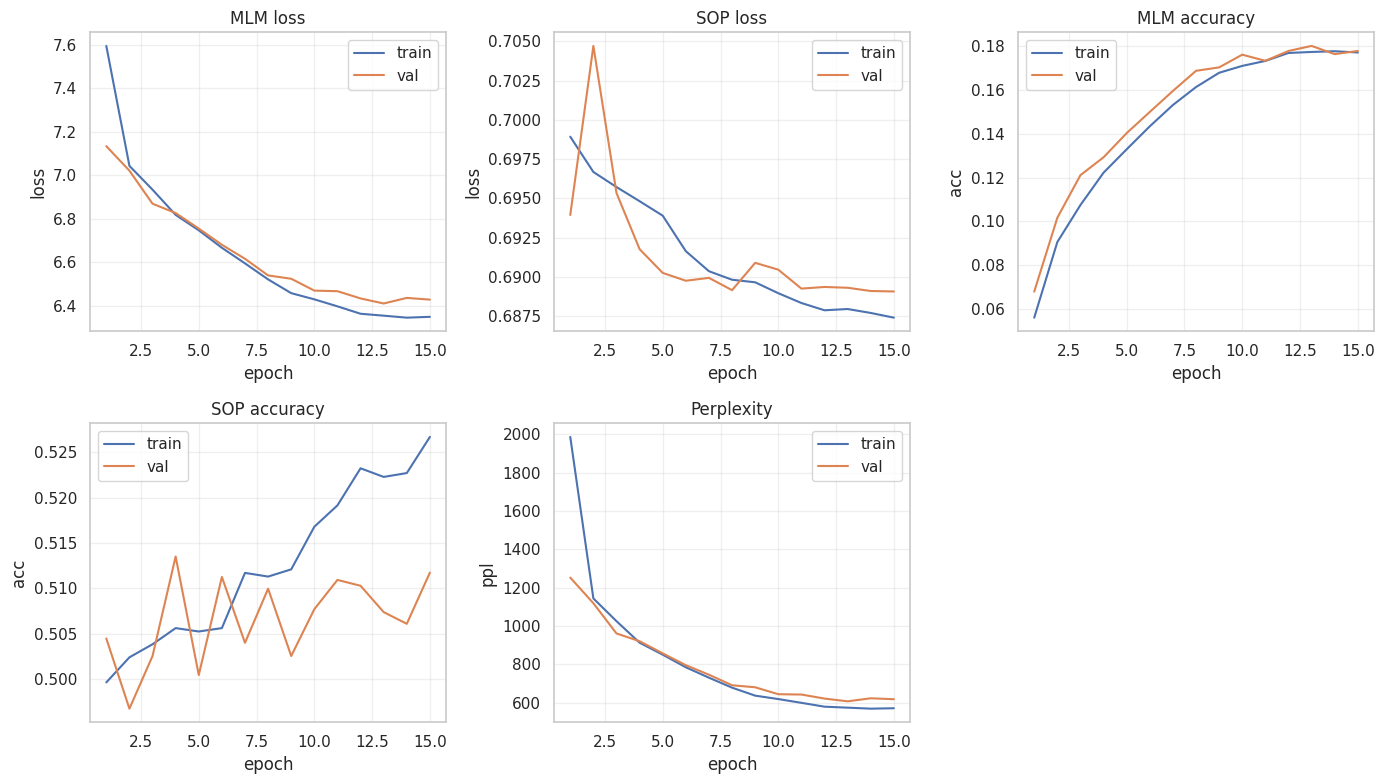

In [39]:
train_epochs = list(range(1, len(train_metrics["train_mlm_loss"]) + 1))
val_epochs = val_metrics.get("epoch", [])

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()

def plot_metric(ax, train_key, val_key, title, ylabel):
    ax.plot(train_epochs, train_metrics[train_key], label="train")
    if val_epochs:
        ax.plot(val_epochs, val_metrics[val_key], label="val")
    ax.set_title(title)
    ax.set_xlabel("epoch")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, alpha=0.3)

plot_metric(axes[0], "train_mlm_loss", "val_mlm_loss", "MLM loss", "loss")
plot_metric(axes[1], "train_sop_loss", "val_sop_loss", "SOP loss", "loss")
plot_metric(axes[2], "train_mlm_acc", "val_mlm_acc", "MLM accuracy", "acc")
plot_metric(axes[3], "train_sop_acc", "val_sop_acc", "SOP accuracy", "acc")
plot_metric(axes[4], "train_ppl", "val_ppl", "Perplexity", "ppl")

axes[5].axis("off")
plt.tight_layout()
plt.show()

Выводы:

- MLM компонента обучается хорошо: loss падает, accuracy растет, perplexity снижается — модель учится восстанавливать скрытые токены;
- SOP почти случайный: точность около 0.5 и loss ~0.69: модель либо не выучила порядок предложений, либо сама задача с текущими настройками слишком слабая;
- метрики для train и val близки: заметного разрыва нет, явного переобучения не наблюдается;
- прирост после ~10 эпох замедляется.  

Имеет место дальнейшее исследование влияния выбранных параметров на обучение, а также применение различных подходов к обучению, будь то другой оптимизатор или планировщик.  

К сожалению, обучение такой небольшой модели на 15 эпох заняло у меня порядка полутора часов, что является проблематичным в виду использование Google Colab и отсутствия своих вычислительных ресурсов. Суровая реальность; отложим полноценное обучение до лучших времен.